In [38]:
using ModelingToolkit
using Plots
using DifferentialEquations
using IfElse
using ModelingToolkit

In [39]:
@variables t
D = Differential(t)

(::Differential) (generic function with 3 methods)

# Defining components

In [40]:
# Pin

@connector Pin begin
    p(t)
    q(t), [connect = Flow]
end

# Ground

@mtkmodel Ground begin
    @components begin
        g = Pin()
    end
    @equations begin
        g.p ~ 0
    end
end

# OnePort

@mtkmodel OnePort begin
    @components begin
        in = Pin()
        out = Pin()
    end
    @variables begin
        Δp(t)
        q(t)
    end
    @equations begin
        Δp ~ out.p - in.p
        0 ~ in.q + out.q
        q ~ in.q
    end
end

# Resistor

@mtkmodel Resistor begin
    @extend OnePort()
    @parameters begin
        R = 1.0 # Sets the default resistance
    end
    @equations begin
        Δp ~ -q * R
    end
end

# Capacitor

@mtkmodel Capacitor begin
    @extend OnePort()
    @parameters begin
        C = 1.0
    end
    @equations begin
        D(Δp) ~ -q / C
    end
end

# Inductor

@mtkmodel Inductor begin
    @extend OnePort()
    @parameters begin
        L = 1.0
    end
    @equations begin
        D(q) ~ -Δp / L
    end
end

# Driven Current

@mtkmodel DrivenCurrent begin
    @extend OnePort()
    @parameters begin
        Q = 1.0
    end
    @equations begin
        q ~ Q * flow(t)
    end
end

LoadError: LoadError: `@extend` only takes an assignment expression. Got OnePort()
in expression starting at In[40]:39

# Bloodflow function

In [41]:
C = 1.1
R = 0.9
R_2 = 1.1
A = 90     # mL/s
B = 1
r = 0.05
L = 0.003

0.003

In [42]:
function flow(t)
    # t = rem(t, B)
    # bloodflow = A*sin(2*π*t/(B))
    bloodflow = A*sin(2*π*t/(B)-pi/2)+A
    return bloodflow
    # return max(0,bloodflow)
    # result = IfElse.ifelse(t<B/4,bloodflow,0)
    # if t<B/4
    #     return bloodflow
    # else
    #     return 0
    # end
end

flow (generic function with 1 method)

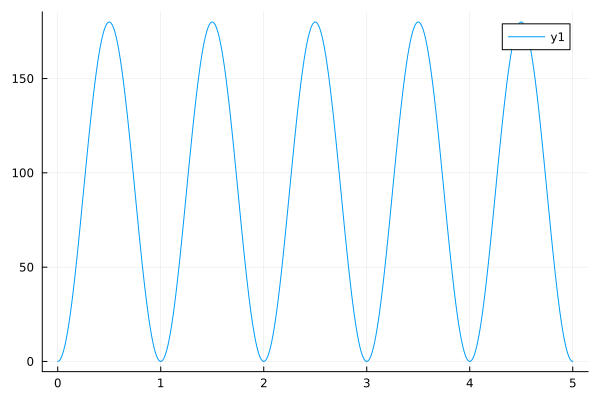

In [43]:
t1 = 0:0.01:5
i = []
for t in t1
    append!(i,flow(t))
end
plot(t1,i)

# 2 element Windkessel
<img src="electric_circuit_diagrams/wk_2.jpg"  width="450" height="250">

In [44]:
@mtkmodel WK2model begin
    @components begin
        resistor = Resistor(R = R_2)
        capacitor = Capacitor(C = C)
        source = DrivenCurrent(Q = 1.0)
        ground = Ground()
    end
    @equations begin
        connect(source.out, resistor.in, capacitor.in)
        connect(resistor.out, source.in, capacitor.out, ground.g)
    end
end

ModelingToolkit.Model{typeof(__WK2model__), Dict{Symbol, Any}}(__WK2model__, Dict{Symbol, Any}(:components => [[:resistor, :Resistor], [:capacitor, :Capacitor], [:source, :DrivenCurrent], [:ground, :Ground]], :kwargs => Dict{Symbol, Any}(:resistor__R => nothing, :capacitor__C => nothing, :source__Q => nothing), :independent_variable => t, :equations => ["connect(source.out, resistor.in, capacitor.in)", "connect(resistor.out, source.in, capacitor.out, ground.g)"]), false)

In [53]:
@mtkbuild wk2model = WK2model()
u0 = [
    wk2model.capacitor.Δp => -78
]
prob = ODEProblem(wk2model, u0, (0, 5.0))
sol_2_elem = solve(prob, RK4(), reltol=1e-6)
plot(sol_2_elem, idxs = wk2model.source.Δp)

LoadError: LoadError: UndefVarError: `@mtkbuild` not defined
in expression starting at In[53]:1

In [46]:
wk2model.resistor

LoadError: UndefVarError: `wk2model` not defined

# 3 element Windkessel
<img src="electric_circuit_diagrams/3_wk.jpg"  width="500" height="250">

In [47]:
@mtkmodel WK3model begin
    @components begin
        resistor_p = Resistor(R = 0.9)
        resistor_c = Resistor(R = 0.05)
        capacitor = Capacitor(C = 1.1)
        source = DrivenCurrent(Q = 1.0)
        ground = Ground()
    end
    @equations begin
        connect(source.out, resistor_c.in)
        connect(resistor_c.out, resistor_p.in, capacitor.in)
        connect(resistor_p.out, capacitor.out, source.in, ground.g)
    end
end

ModelingToolkit.Model{typeof(__WK3model__), Dict{Symbol, Any}}(__WK3model__, Dict{Symbol, Any}(:components => [[:resistor_p, :Resistor], [:resistor_c, :Resistor], [:capacitor, :Capacitor], [:source, :DrivenCurrent], [:ground, :Ground]], :kwargs => Dict{Symbol, Any}(:resistor_c__R => nothing, :resistor_p__R => nothing, :capacitor__C => nothing, :source__Q => nothing), :independent_variable => t, :equations => ["connect(source.out, resistor_c.in)", "connect(resistor_c.out, resistor_p.in, capacitor.in)", "connect(resistor_p.out, capacitor.out, source.in, ground.g)"]), false)

In [48]:
@mtkbuild wk3model = WK3model()
u0 = [
    wk3model.capacitor.Δp => -78
]
prob = ODEProblem(wk3model, u0, (0, 6.0))
sol_3_elem = solve(prob, RK4(), reltol=1e-6)
plot(sol_3_elem, idxs = [wk3model.source.Δp])#,wk3model.capacitor.Δp+wk3model.resistor_c.Δp])

LoadError: LoadError: UndefVarError: `@mtkbuild` not defined
in expression starting at In[48]:1

# 4 element Windkessel
<img src="electric_circuit_diagrams/4_wk.jpg"  width="700" height="250">

In [49]:
@mtkmodel WK4model begin
    @components begin
        resistor_p = Resistor(R = R)
        resistor_c = Resistor(R = r)
        capacitor = Capacitor(C = C)
        inductor = Inductor(L=L)
        source = DrivenCurrent(Q = 1.0)
        ground = Ground()
    end
    @equations begin
        connect(source.out, resistor_c.in)
        connect(resistor_c.out, inductor.in)
        connect(inductor.out, resistor_p.in, capacitor.in)
        connect(resistor_p.out, capacitor.out, source.in, ground.g)
    end
end

ModelingToolkit.Model{typeof(__WK4model__), Dict{Symbol, Any}}(__WK4model__, Dict{Symbol, Any}(:components => [[:resistor_p, :Resistor], [:resistor_c, :Resistor], [:capacitor, :Capacitor], [:inductor, :Inductor], [:source, :DrivenCurrent], [:ground, :Ground]], :kwargs => Dict{Symbol, Any}(:inductor__L => nothing, :resistor_c__R => nothing, :resistor_p__R => nothing, :capacitor__C => nothing, :source__Q => nothing), :independent_variable => t, :equations => ["connect(source.out, resistor_c.in)", "connect(resistor_c.out, inductor.in)", "connect(inductor.out, resistor_p.in, capacitor.in)", "connect(resistor_p.out, capacitor.out, source.in, ground.g)"]), false)

In [50]:
wk4model

LoadError: UndefVarError: `wk4model` not defined

In [51]:
@mtkbuild wk4model = WK4model()
u0 = [
    wk4model.capacitor.Δp => -78
]
prob = ODEProblem(wk4model, u0, (0, 6.0))
sol_4_elem = solve(prob, RK4(), reltol=1e-6)
plot(sol_4_elem, idxs = wk4model.source.Δp)

LoadError: LoadError: UndefVarError: `@mtkbuild` not defined
in expression starting at In[51]:1

# Comparison

In [52]:
plot(sol_2_elem, idxs = wk2model.source.Δp, labels="2 element", ylabel="Pressure")
plot!(sol_3_elem, idxs = wk3model.source.Δp, labels="3 element")
# plot!(twinx(), t1, i, c=:black, ls=:dash)
plot!(sol_4_elem, idxs = wk4model.source.Δp, labels="4 element")
# plot!(sol_4_elem_alt, idxs = wk4model_alt.source.Δp, labels="4 element alternative")

LoadError: UndefVarError: `wk2model` not defined